In [5]:
import os, sys
#os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
#os.environ['CUDA_VISIBLE_DEVICES'] = '0'
os.environ['CUDA_VISIBLE_DEVICES'] = '1'
import tensorflow as tf
tf.compat.v1.enable_eager_execution()
import numpy as np
import imageio
from PIL import Image as im
import pprint
import matplotlib.pyplot as plt
%matplotlib inline
import run_nerf
import run_nerf_helpers


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [ ]:
#Load trained network weights
#Run bash download_example_weights.sh in the root directory if you need to download the Lego example weights


basedir = './logs'
expname = 'lego_example'

config = os.path.join(basedir, expname, 'config.txt')
print('Args:')
print(open(config, 'r').read())

parser = run_nerf.config_parser()
ft_str = '--ft_path {}'.format(os.path.join(basedir, expname, 'model_200000.npy'))
args = parser.parse_args('--config {} '.format(config) + ft_str)

# Create nerf model
_, render_kwargs_test, start, grad_vars, models = run_nerf.create_nerf(args)

bds_dict = {
    'near' : tf.cast(2., tf.float32),
    'far' : tf.cast(6., tf.float32),
}
render_kwargs_test.update(bds_dict)

print('Render kwargs:')
pprint.pprint(render_kwargs_test)

net_fn = render_kwargs_test['network_query_fn']
print(net_fn)

#Render an overhead view to check model was loaded correctly
c2w = np.eye(4)[:3,:4].astype(np.float32) # identity pose matrix
c2w[2,-1] = 4.
H, W, focal = 800, 800, 1200.
down = 8
test = run_nerf.render(H//down, W//down, focal/down, c2w=c2w, **render_kwargs_test)
img = np.clip(test[0],0,1)
# plt.imshow(img)
# plt.show()


(257, 257, 257, 3)


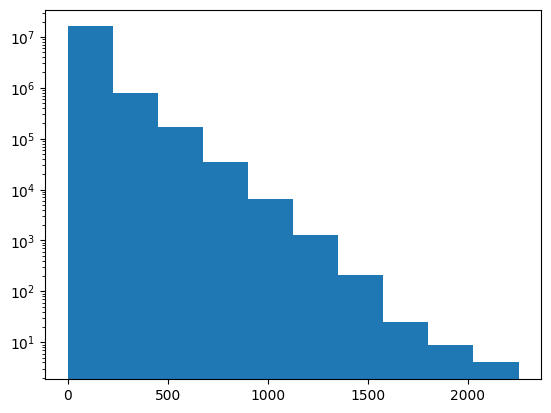

In [ ]:
#Query network on dense 3d grid of points

N = 256
t = np.linspace(-1.3, 1.3, N+1)          

query_pts = np.stack(np.meshgrid(t, t, t), -1).astype(np.float32)
print(query_pts.shape)
sh = query_pts.shape
flat = query_pts.reshape([-1,3])       

viewdirs = np.zeros_like(flat)
def batchify(fn, chunk):
    if chunk is None:
        return fn
    def ret(inputs):
        return tf.concat([fn(inputs[i:i+chunk]) for i in range(0, inputs.shape[0], chunk)], 0)
    return ret


                                                
fn = lambda i0, i1 : net_fn(flat[i0:i1,None,:],  viewdirs=viewdirs[i0:i1,:], network_fn=render_kwargs_test['network_fine'])
#fn = lambda i0, i1 : net_fn(flat[i0:i1,None,:], viewdirs=np.zeros_like(flat[i0:i1]), network_fn=render_kwargs_test['network_fine'])
chunk = 1024*64
raw = np.concatenate([fn(i, i+chunk).numpy() for i in range(0, flat.shape[0], chunk)], 0)
raw = np.reshape(raw, list(sh[:-1]) + [-1])
sigma = np.maximum(raw[...,-1], 0.)

In [ ]:
#Marching cubes algorithm PyMCubes

import mcubes

threshold = 50                     #   threshold = 50.
print('fraction occupied', np.mean(sigma > threshold))
vertices, triangles = mcubes.marching_cubes(sigma, threshold)
print('done', vertices.shape, triangles.shape)

 #Uncomment to save out the mesh
    
mcubes.export_mesh(vertices, triangles, "logs/lego_example/lego_{}.dae".format(N), "lego")

fraction occupied 0.19881383901222255
done (1783614, 3) (3535890, 3)


In [ ]:
#Interactive mesh

import trimesh

mesh = trimesh.Trimesh(vertices / N - .10, triangles)            # mesh = trimesh.Trimesh(vertices / N - .10, triangles)
mesh.show()

In [ ]:
# mesh
mesh =  trimesh.Trimesh(vertices / N - .10, triangles)  
mesh.compute_vertex_normals()
o3d.visualization.draw_geometries([mesh])

In [ ]:
#Save out video with pyrender
# os.environ["PYOPENGL_PLATFORM"] = "egl"
import pyrender
from load_blender import pose_spherical

In [ ]:
import pyrender
import trimesh


mesh = trimesh.Trimesh(vertices / N - .10, triangles)            # mesh = trimesh.Trimesh(vertices / N - .10, triangles)
mesh.show()
scene = pyrender.Scene()
scene.add(pyrender.Mesh.from_trimesh(mesh, smooth=True))

# Set up the camera -- z-axis away from the scene, x-axis right, y-axis up
camera = pyrender.PerspectiveCamera(yfov=np.pi / 3.0)

#camera_pose = pose_spherical(-180., 8., 1.).numpy() # for lego
#camera_pose = pose_spherical(-100., -5., 1.).numpy() # for chair
#camera_pose = pose_spherical(+90., +110., 1.).numpy() # for fern
#camera_pose = pose_spherical(+90., +105., 1.).numpy() # for room
#camera_pose = pose_spherical(-140., -25., 1.).numpy() # for ship
camera_pose = pose_spherical(-120., 10., 1.).numpy() # for drums
nc = pyrender.Node(camera=camera, matrix=camera_pose)
scene.add_node(nc)

# Set up the light -- a point light in the same spot as the camera
light = pyrender.PointLight(color=np.ones(3), intensity=4.0)
nl = pyrender.Node(light=light, matrix=camera_pose)
scene.add_node(nl)

# Render the scene
r = pyrender.OffscreenRenderer(640, 480)
color, depth = r.render(scene)

plt.imshow(color)
plt.show()
plt.imshow(depth)
plt.show()


In [ ]:
imgs = []

#for th in np.linspace(0, 360., 120+1)[:-1]:
for th in np.linspace(10, 360., 120+1)[:-1]:
    camera_pose = pose_spherical(th, -40., 1.).numpy()
    scene.set_pose(nc, pose=camera_pose)
    imgs.append(r.render(scene)[0])
f = 'logs/lego_example/lego_mesh_turntable.mp4'
imageio.mimwrite(f, imgs, fps=30)
print('done')

done


In [ ]:
from IPython.display import HTML
from base64 import b64encode
mp4 = open(f,'rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=400 controls autoplay loop>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)